In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import seaborn as sns
# pip install odfpy

In [2]:
def reshape_table_by_gender(df, end_columns_identifier, gender, year):
    """
    This function reshapes a DataFrame by filtering and transforming it based on the input gender and year.
    
    Parameters:
        df (DataFrame): The input DataFrame to reshape.
        end_columns_identifier (str): A string that identifies the columns in the DataFrame to select.
        gender (str): The gender to filter the DataFrame by.
        year (str): The year to filter the DataFrame by.
        
    Returns:
        DataFrame: The reshaped and filtered DataFrame.
    """
    # Removing NaNs
    df.dropna(inplace=True)

    # Renaming the 2 columns refering to the department and departement code
    df = df.rename(columns={"Unnamed: 0": "dep_code", "Unnamed: 1": "dep"})

    # Selecting the columns for a given gender
    # Gérer aussi "95 ans et plus" sans complexifier de trop
    df = df.loc[:, (df.columns.str.endswith(end_columns_identifier)) | (df.columns == "dep_code") | (df.columns == "dep")]

    # Removing the ".1" and ".2" at the end of the column names
    df.columns = [column_name.replace(end_columns_identifier, "ans") for column_name in df.columns.to_list()]

    # Going from a wide to a long DataFrame with population as the column value
    df = pd.melt(df, id_vars=['dep_code', 'dep'], value_name="population", var_name="age")

    # Adding a gender column
    df["genre"] = gender

    # Adding a year column
    df["annee"] = year

    # Making sure that population column is numeric
    df["population"] = df["population"].astype("int64")

    # Making sure that department code column is a string (problems with 0 and overseas territories)
    df["dep_code"] = df["dep_code"].astype(str)
    
    return df

In [3]:
def plot_population_by_gender_per_department(df, department_code):
    """
    This function plots the evolution of population by gender for a given department code.
    
    Parameters:
        df (DataFrame): The input DataFrame containing population data.
        department_code (str): The department code to filter the DataFrame by.
        
    Returns:
        None. Displays a line chart of population evolution by gender for the specified department.
    """

    # Filter the DataFrame by department code
    df = df[df["dep_code"] == department_code]
    
    # Filter out the total population rows
    df = df[df["genre"] != "Total"]
    
    # Create a pivot table with population values by year and gender
    df_pivot = df.pivot_table(values='population', index='annee', columns='genre', aggfunc='sum')

    # Get the department name for the title
    department_name = pd.unique(df['dep'])[0]
    
    # Plot the data
    df_pivot.plot(kind='line')

    # Set x-axis label
    plt.xlabel('Année')
    # Set y-axis label
    plt.ylabel('Population')
    # Set chart title
    plt.title(f"Evolution de la population entre 1975 et 2022 dans le {department_code} ({department_name})")
    # Set legend
    plt.legend(title="Genre")
    # Show the chart
    plt.show()

In [71]:
def compute_population_growth_per_region(df):
    df = df[df["genre"] != "Total"]
    df = df.pivot_table(values='population', index='annee', columns='region_name', aggfunc='sum')
    return df.pct_change() * 100
    

In [92]:
def compute_mean_population_growth_per_region(df, min_year, max_year):
    df = compute_population_growth(df)
    df.reset_index(inplace=True)
    df = df[(df["annee"] >= min_year) & (df["annee"] <= max_year)]
    df = pd.melt(df, id_vars=['annee'], value_name="croissance_pop", var_name="region")
    return df.groupby("region").mean()


In [232]:
def compute_age_pyramid(df, year):
    df = df.groupby(["age", "genre", "annee"]).sum("population")
    df = df.unstack(["genre"])
    df.columns = df.columns.droplevel(level=0)
    df = df.reset_index()
    df["Homme"] = df["Homme"] * -1
    sample = df[df["annee"] == year]
    return sample

In [242]:
def plot_age_pyramid(df, year, ax=None):
    data = compute_age_pyramid(df, year)
    idx = [f"{i-4} à {i} ans" for i in range(94, 0, -5)]
    
    if ax is None:
        ax = plt.gca()
    ax1 = sns.barplot(x='Homme', y='age', data=data, order=idx, palette="Blues", ax=ax)
    ax2 = sns.barplot(x='Femme', y='age', data=data, order=idx, palette="Greens", ax=ax)
    ax1.set(ylabel=None)
    ax1.set_title(f"Pyramides des âges de la France en {year}")
    ax1.set_xlabel("Homme - Femme")
    ax1.grid()


On importe données depuis le site de l'insee sur le Recensement. Malheureusement donnée en excel donc plusieurs modifications à effectuer pour netoyer ce fichier afin d'analyser les statistique

In [8]:
data = pd.read_excel("https://minio.lab.sspcloud.fr/tfaria/public/estim-pop-dep-sexe-aq-1975-2022.ods", engine="odf", sheet_name=None, header=4)

On importe tous les onglets du fichiers excel et on les nettoie de sorte à avoir un dataframe contenant toutes les infos.

In [9]:
ids = {"Total": "ans", "Homme": "ans.1", "Femme": "ans.2"}
df = pd.concat(
    [
        reshape_table_by_gender(data[f"{year}"], value, key, year) # On récupère le dataframe pour un genre et une année donnée
        for key, value in ids.items()
        for year in range(1975, 2023)
    ]
)

On créer une fonction pour visualiser l'évolution de la population en 1975 et 2022 pour un département données

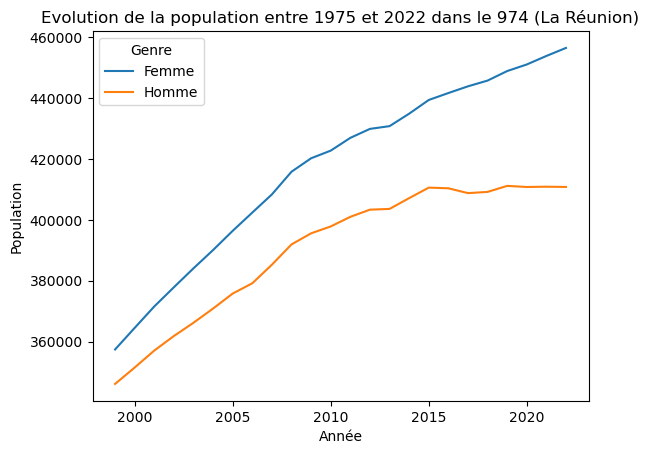

In [10]:
plot_population_by_gender_per_department(df, "974")

Apparier avec les régions. Import d'un fichier json

In [11]:
regions = pd.read_json("https://static.data.gouv.fr/resources/departements-et-leurs-regions/20190815-175403/departements-region.json")
regions["num_dep"] = regions["num_dep"].astype(str)

In [12]:
df_regions = pd.merge(df, regions, left_on=['dep_code'],right_on=['num_dep'])

Calcul de la population par région en 2022

In [103]:
sample = df_regions[df_regions["annee"] == 2022]

In [104]:
sample = sample.groupby(by=["region_name"]).sum("population")

In [19]:
geo = gpd.read_file("https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=REGION/crs=4326/FRANCE_ENTIERE=metropole/vectorfile_format='geojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.geojson")

https://geopandas.org/en/stable/docs/user_guide/mapping.html

In [105]:
regions_geo = geo.merge(sample.reset_index(), right_on=['region_name'],left_on=['NOM'])

<AxesSubplot: >

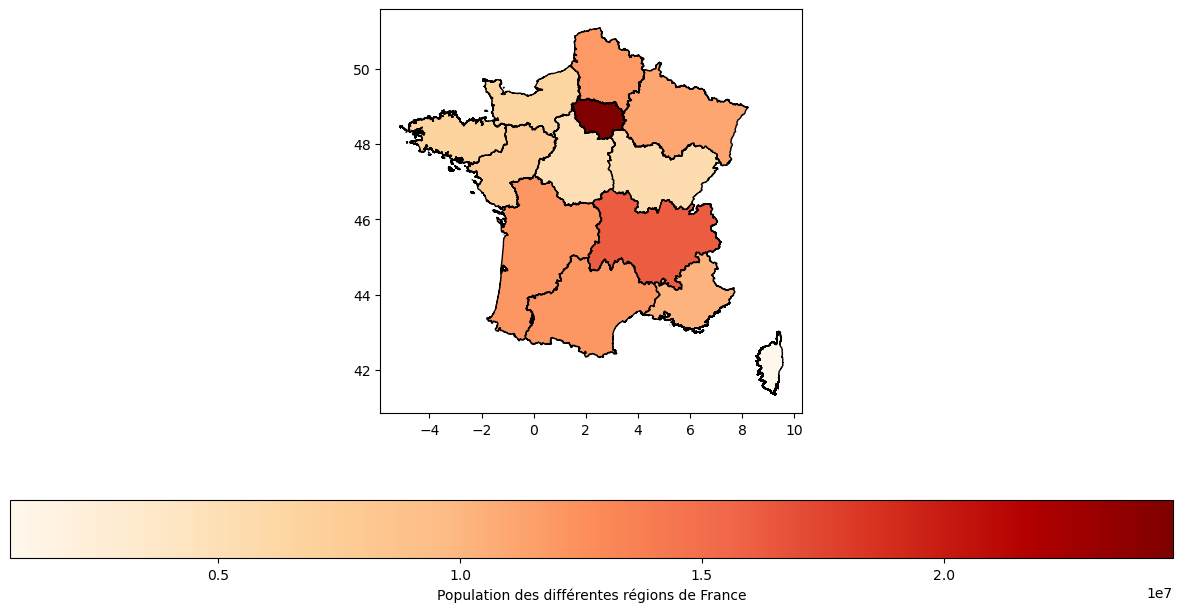

In [106]:
regions_geo.plot(column = 'population',
                      legend = True,
                      cmap='OrRd',
                      edgecolor="black",
                      figsize = [15,7.5],\
                      legend_kwds = {'label': "Population des différentes régions de France",
                                    'orientation': "horizontal"})

In [95]:
annee_min = 2010
annee_max = 2022
sample = compute_mean_population_growth_per_region(df_regions, annee_min, annee_max)


In [101]:
regions_geo2 = geo.merge(sample.reset_index(), left_on=['NOM'], right_on=['region'])

<AxesSubplot: >

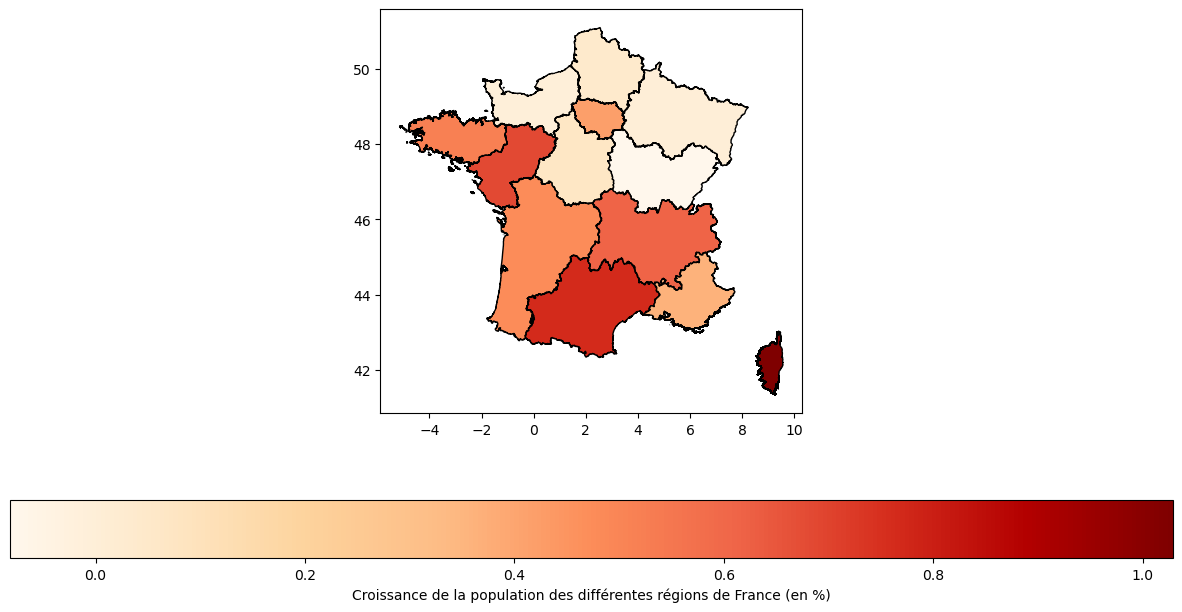

In [102]:
regions_geo2.plot(column = 'croissance_pop',
                      legend = True,
                      cmap='OrRd',
                      edgecolor="black",
                      figsize = [15,7.5],\
                      legend_kwds = {'label': "Croissance de la population des différentes régions de France (en %)",
                                    'orientation': "horizontal"})

<AxesSubplot: >

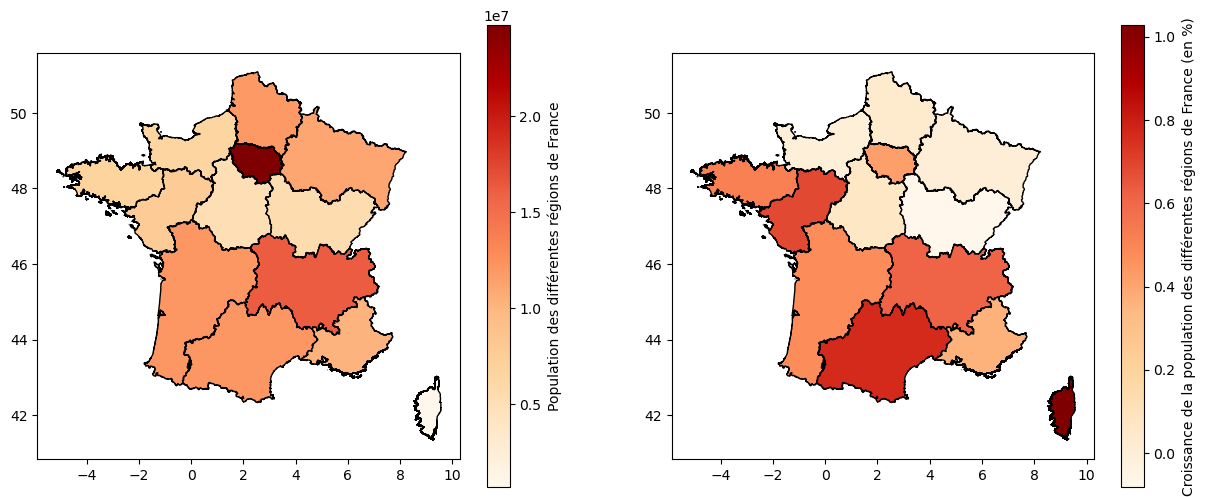

In [117]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

regions_geo.plot(column = 'population',
                      legend = True,
                      cmap='OrRd',
                      edgecolor="black",
                      ax=ax1,
                      legend_kwds = {'label': "Population des différentes régions de France"})

regions_geo2.plot(column = 'croissance_pop',
                      legend = True,
                      cmap='OrRd',
                      edgecolor="black",
                      ax=ax2,
                      legend_kwds = {'label': "Croissance de la population des différentes régions de France (en %)"})


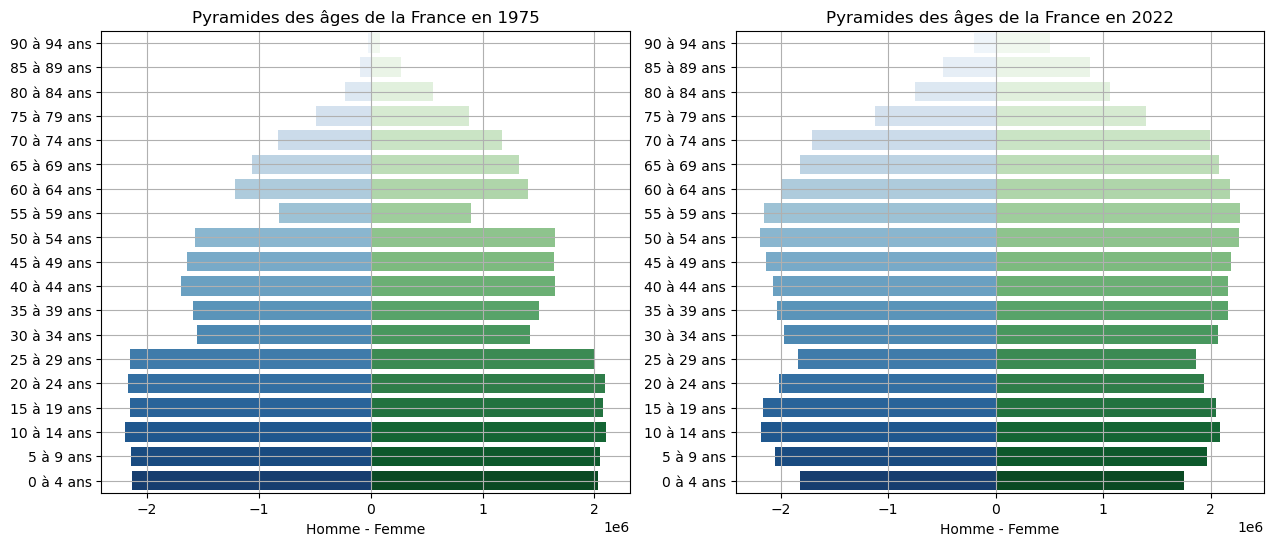

In [244]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

plot_age_pyramid(df, 1975, ax=ax1)
plot_age_pyramid(df, 2022, ax=ax2)